# Import the necessary packages

In [215]:
import pandas as pd
import pylab as pl
import seaborn as sn
import numpy as np
import zipfile
import geopandas as gp
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn import mixture
from fiona.crs import from_epsg

%pylab inline


Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['colors', 'dist']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Import the Zillow data for rent value across the US by Zip Code

In [2]:
rent = pd.read_csv("Zip_rent.csv")

In [3]:
rent.head()

RegionID  RegionName         City State              Metro CountyName  \
0     61639       10025     New York    NY           New York   New York   
1     84654       60657      Chicago    IL            Chicago       Cook   
2     61637       10023     New York    NY           New York   New York   
3     90668       75070     McKinney    TX  Dallas-Fort Worth     Collin   
4     91982       77494  Cinco Ranch    TX            Houston  Fort Bend   

   SizeRank  2010-11  2010-12  2011-01   ...     2017-05  2017-06  2017-07  \
0         1      NaN      NaN      NaN   ...        3538     3527     3537   
1         2   1731.0   1742.0   1750.0   ...        1879     1889     1896   
2         3      NaN      NaN      NaN   ...        3791     3799     3848   
3         4   1577.0   1576.0   1582.0   ...        1927     1928     1930   
4         5   2184.0   2185.0   2181.0   ...        2157     2153     2154   

   2017-08  2017-09  2017-10  2017-11  2017-12  2018-01  2018-02  
0     3551     3572     3579     3576     3555     3528     3509  
1     1902     1905     1906     1897     1886     1877     1872  
2     3899     3944     3946     3919     3869     3831     3782  
3     1930     1930     1930     1929     1923     1915     1908  
4     2154     2154     2153     2159     2170     2182     2191  

[5 rows x 95 columns]

# Filter only Zipcodes located in California

In [4]:
rent_ca = rent[rent["State"] == "CA"]

In [5]:
print (rent.shape)
print (rent_ca.shape)

(15921, 95)
(1244, 95)


# Read the Zipcodes polygon shapefile that TIGER has.

In [8]:
zip_ref = zipfile.ZipFile("tl_2015_us_zcta510.zip", 'r')
zip_ref.extractall()
zip_ref.close()

In [11]:
zipcodes = gp.GeoDataFrame.from_file("tl_2015_us_zcta510.shp")

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


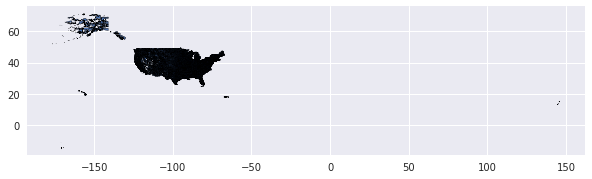

In [13]:
zipcodes.plot(figsize(10,10), edgecolor = "black")


In [14]:
zipcodes.head()

ZCTA5CE10 GEOID10 CLASSFP10 MTFCC10 FUNCSTAT10    ALAND10  AWATER10  \
0     43451   43451        B5   G6350          S   63411475    157689   
1     43452   43452        B5   G6350          S  121783676  13437379   
2     43456   43456        B5   G6350          S    9389361    999166   
3     43457   43457        B5   G6350          S   48035540         0   
4     43458   43458        B5   G6350          S    2573816     39915   

    INTPTLAT10    INTPTLON10  \
0  +41.3183010  -083.6174935   
1  +41.5157923  -082.9809454   
2  +41.6468445  -082.8226641   
3  +41.2673266  -083.4274645   
4  +41.5304461  -083.2133648   

                                            geometry  
0  POLYGON ((-83.674464 41.331119, -83.6744449999...  
1  POLYGON ((-83.067745 41.537718, -83.067729 41....  
2  (POLYGON ((-82.8566 41.681222, -82.856831 41.6...  
3  POLYGON ((-83.467474 41.268186, -83.4676039999...  
4  POLYGON ((-83.222292 41.531025, -83.2222819999...

# Check the variable that contains the zipcode in both datasets so that we can merge properly. Transform it into a string.

In [18]:
print (type(zipcodes.ZCTA5CE10.iloc[1]))
print (type(rent_ca.RegionName.iloc[1]))

<class 'str'>
<class 'numpy.int64'>


In [19]:
rent_ca["RegionName"] = rent_ca.RegionName.astype(str)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [20]:
print (type(zipcodes.ZCTA5CE10.iloc[1]))
print (type(rent_ca.RegionName.iloc[1]))

<class 'str'>
<class 'str'>


# Merge the datasets

In [21]:
zips = pd.merge(rent_ca, zipcodes, right_on = "ZCTA5CE10", left_on = "RegionName")

In [22]:
zips.head()

RegionID RegionName           City State                           Metro  \
0     97564      94109  San Francisco    CA                   San Francisco   
1     96107      90250      Hawthorne    CA  Los Angeles-Long Beach-Anaheim   
2     97771      94565      Pittsburg    CA                   San Francisco   
3     96027      90046    Los Angeles    CA  Los Angeles-Long Beach-Anaheim   
4     97711      94501        Alameda    CA                   San Francisco   

      CountyName  SizeRank  2010-11  2010-12  2011-01  \
0  San Francisco        13   2983.0   3002.0   3021.0   
1    Los Angeles        19   2127.0   2099.0   2087.0   
2   Contra Costa        34   1612.0   1633.0   1637.0   
3    Los Angeles        37   2922.0   2944.0   2961.0   
4        Alameda        74   2073.0   2079.0   2110.0   

                         ...                          ZCTA5CE10  GEOID10  \
0                        ...                              94109    94109   
1                        ...                              90250    90250   
2                        ...                              94565    94565   
3                        ...                              90046    90046   
4                        ...                              94501    94501   

   CLASSFP10  MTFCC10  FUNCSTAT10   ALAND10  AWATER10   INTPTLAT10  \
0         B5    G6350           S   3077741    295388  +37.7953881   
1         B5    G6350           S  17339111     35693  +33.9147753   
2         B5    G6350           S  78215739   9559562  +38.0145762   
3         B5    G6350           S  14980562      3009  +34.1078099   
4         B5    G6350           S  20513096   9031622  +37.7737930   

     INTPTLON10                                           geometry  
0  -122.4224441  POLYGON ((-122.426671 37.809639, -122.426625 3...  
1  -118.3480828  POLYGON ((-118.317782 33.919224, -118.317782 3...  
2  -121.9062550  POLYGON ((-121.885177 38.047591, -121.88502 38...  
3  -118.3622474  POLYGON ((-118.374841 34.102112, -118.375092 3...  
4  -122.2781151  POLYGON ((-122.236488 37.771696, -122.236355 3...  

[5 rows x 105 columns]

In [23]:
zips.shape

(1243, 105)

# Make a quick plot to see how California looks like

In [25]:
cali = gp.GeoDataFrame(zips)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


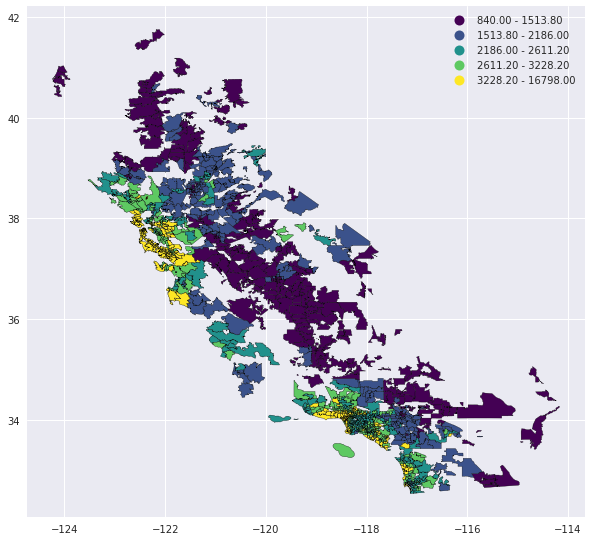

In [27]:
cali.plot(figsize=(10,10),column='2017-12',cmap='viridis',edgecolor='black',legend=True, scheme = "quantiles")

# It is not a great map and it is hard to get any valuable information from it, specially because we have a big amount of missing zip-codes, probably because there is no real state data for those, therefor we decide to focus only in the LA metro area.

In [28]:
los_angeles = cali[cali["Metro"] == "Los Angeles-Long Beach-Anaheim"]

# Calculation for the average rent price for every Zip Code in LA for foth 2014 and 2017. After we calculate the absolute difference between the average value of both years and also the percentual change in the value.

In [44]:
los_angeles["average_rent_2017"] = (los_angeles["2017-01"] + los_angeles["2017-02"] + los_angeles["2017-03"] + los_angeles["2017-04"] + los_angeles["2017-05"] + los_angeles["2017-06"] + los_angeles["2017-07"] + los_angeles["2017-08"] + los_angeles["2017-09"] + los_angeles["2017-10"] + los_angeles["2017-11"] + los_angeles["2017-12"])/12
los_angeles["average_rent_2014"] = (los_angeles["2014-01"] + los_angeles["2014-02"] + los_angeles["2014-03"] + los_angeles["2014-04"] + los_angeles["2014-05"] + los_angeles["2014-06"] + los_angeles["2014-07"] + los_angeles["2014-08"] + los_angeles["2014-09"] + los_angeles["2014-10"] + los_angeles["2014-11"] + los_angeles["2014-12"])/12

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [45]:
los_angeles["increase_3_year"] = los_angeles["average_rent_2017"] / los_angeles["average_rent_2014"]
los_angeles["3_year_absolute_rent_increase"] = los_angeles["average_rent_2017"]-los_angeles["average_rent_2014"]





/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


# Do 3 descriptive plots, Average rent price in 2017, Percentual rent increase and Absolute change.

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


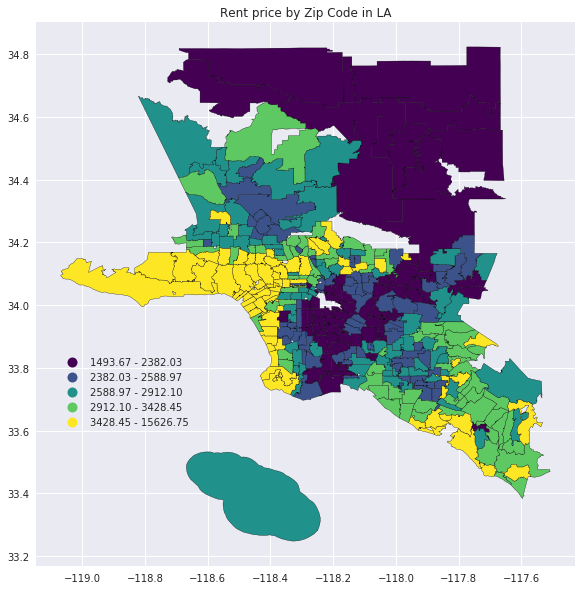

In [51]:
ax = los_angeles.plot(figsize=(10,10),column='average_rent_2017',cmap='viridis',edgecolor='black',legend=True, scheme = "quantiles")
plt.title("Rent price by Zip Code in LA")
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.1, 0.2, 0.2, 0.2))

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


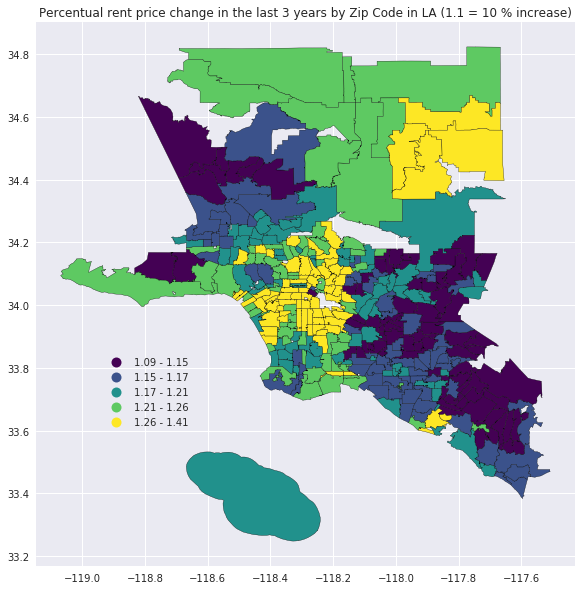

In [49]:
ax = los_angeles.plot(figsize=(10,10),column='increase_3_year',cmap='viridis',edgecolor='black',legend=True, scheme = "quantiles")
plt.title("Percentual rent price change in the last 3 years by Zip Code in LA (1.1 = 10 % increase)")
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.1, 0.2, 0.2, 0.2))

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


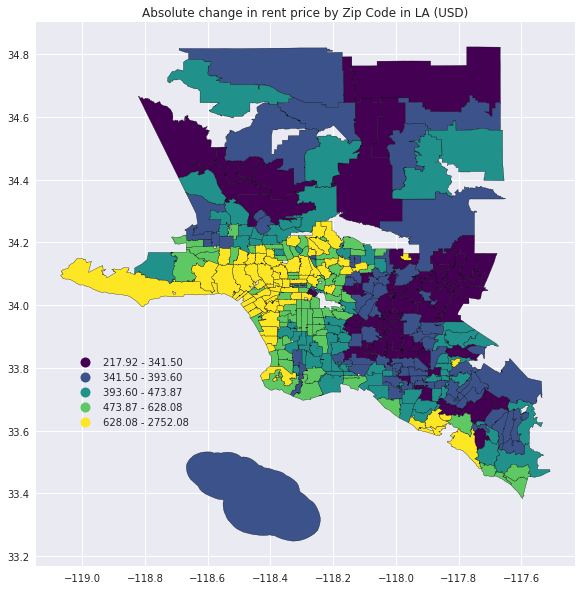

In [50]:
ax = los_angeles.plot(figsize=(10,10),column='3_year_absolute_rent_increase',cmap='viridis',edgecolor='black',legend=True, scheme = "quantiles")
plt.title("Absolute change in rent price by Zip Code in LA (USD)")
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.1, 0.2, 0.2, 0.2))

# Lets do some linear correlation plots to see how the average rent price in 2014 is correlated to the percentual change and the absolute change in rent prices. Meaning that we want to check how the original value of the property can explain an increase in the property value, either percentually or in absolute terms.

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Text(0.5,33,'Percentual Increase in last 3 years')

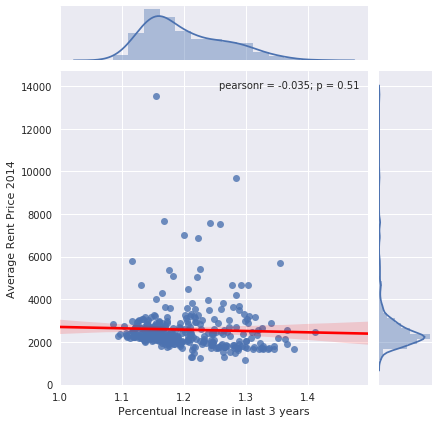

In [82]:
cambio_porcentual = sn.jointplot("increase_3_year", "average_rent_2014", data=los_angeles, kind='reg',
                  joint_kws={'line_kws':{'color':'red'}})
pl.ylabel("Average Rent Price 2014")
pl.xlabel("Percentual Increase in last 3 years")

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Text(0.5,33,'Absolute Increase in last 3 years')

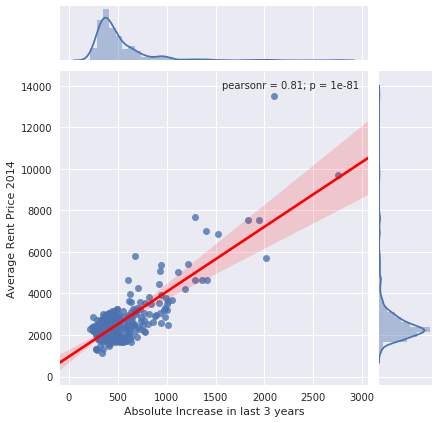

In [81]:
cambio_absoluto = sn.jointplot("3_year_absolute_rent_increase", "average_rent_2014", data=los_angeles, kind='reg',
                  joint_kws={'line_kws':{'color':'red'}})
pl.ylabel("Average Rent Price 2014")
pl.xlabel("Absolute Increase in last 3 years")

# Oh, how interesting! the absolute value increase is very closely correlated to the absolute value of rent, nevertheless you cannot say the same about the porcentual rent increase, where there is no significant correlation. This means that expensive properties gain more value in absolute terms, but not necessarily when measuring it as a percentual increase.

# Now let's do it for property Value

In [57]:
h_value = pd.read_csv("Zip_home_value.csv")

In [58]:
h_value_ca = h_value[h_value["State"] == "CA"]

In [59]:
print (type(zipcodes.ZCTA5CE10.iloc[1]))
print (type(h_value_ca.RegionName.iloc[1]))

<class 'str'>
<class 'numpy.int64'>


In [60]:
h_value_ca["RegionName"] = h_value_ca.RegionName.astype(str)
zips1 = pd.merge(h_value_ca, zipcodes, right_on = "ZCTA5CE10", left_on = "RegionName")

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [61]:
zips1.head()

RegionID RegionName           City State                           Metro  \
0     97564      94109  San Francisco    CA                   San Francisco   
1     96107      90250      Hawthorne    CA  Los Angeles-Long Beach-Anaheim   
2     97771      94565      Pittsburg    CA                   San Francisco   
3     96027      90046    Los Angeles    CA  Los Angeles-Long Beach-Anaheim   
4     97711      94501        Alameda    CA                   San Francisco   

      CountyName  SizeRank   1996-04   1996-05   1996-06  \
0  San Francisco        10  298200.0  295700.0  296400.0   
1    Los Angeles        16       NaN       NaN       NaN   
2   Contra Costa        24  122500.0  122200.0  122100.0   
3    Los Angeles        27  264500.0  265000.0  266600.0   
4        Alameda        57  206900.0  207900.0  208100.0   

                         ...                          ZCTA5CE10  GEOID10  \
0                        ...                              94109    94109   
1                        ...                              90250    90250   
2                        ...                              94565    94565   
3                        ...                              90046    90046   
4                        ...                              94501    94501   

   CLASSFP10  MTFCC10  FUNCSTAT10   ALAND10  AWATER10   INTPTLAT10  \
0         B5    G6350           S   3077741    295388  +37.7953881   
1         B5    G6350           S  17339111     35693  +33.9147753   
2         B5    G6350           S  78215739   9559562  +38.0145762   
3         B5    G6350           S  14980562      3009  +34.1078099   
4         B5    G6350           S  20513096   9031622  +37.7737930   

     INTPTLON10                                           geometry  
0  -122.4224441  POLYGON ((-122.426671 37.809639, -122.426625 3...  
1  -118.3480828  POLYGON ((-118.317782 33.919224, -118.317782 3...  
2  -121.9062550  POLYGON ((-121.885177 38.047591, -121.88502 38...  
3  -118.3622474  POLYGON ((-118.374841 34.102112, -118.375092 3...  
4  -122.2781151  POLYGON ((-122.236488 37.771696, -122.236355 3...  

[5 rows x 280 columns]

In [62]:
cali1 = gp.GeoDataFrame(zips1)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


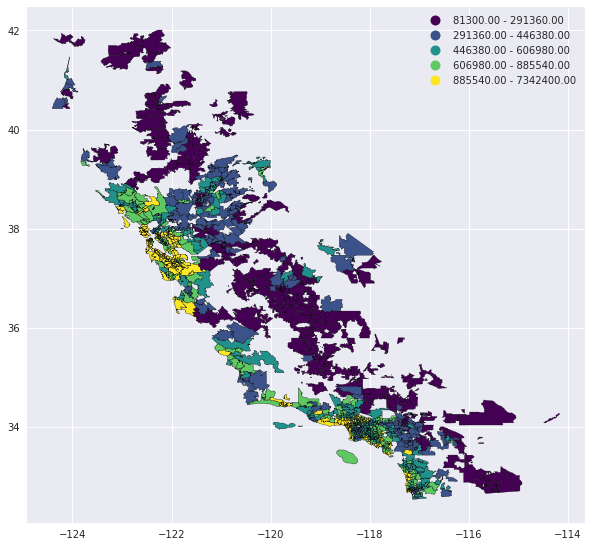

In [63]:
cali1.plot(figsize=(10,10),column='2017-12',cmap='viridis',edgecolor='black',legend=True, scheme = "quantiles")

In [64]:
los_angeles1 = cali1[cali1["Metro"] == "Los Angeles-Long Beach-Anaheim"]

In [70]:
los_angeles1["average_hv_2017"] = (los_angeles1["2017-01"] + los_angeles1["2017-02"] + los_angeles1["2017-03"] + los_angeles1["2017-04"] + los_angeles1["2017-05"] + los_angeles1["2017-06"] + los_angeles1["2017-07"] + los_angeles1["2017-08"] + los_angeles1["2017-09"] + los_angeles1["2017-10"] + los_angeles1["2017-11"] + los_angeles1["2017-12"])/12
los_angeles1["average_hv_2014"] = (los_angeles1["2014-01"] + los_angeles1["2014-02"] + los_angeles1["2014-03"] + los_angeles1["2014-04"] + los_angeles1["2014-05"] + los_angeles1["2014-06"] + los_angeles1["2014-07"] + los_angeles1["2014-08"] + los_angeles1["2014-09"] + los_angeles1["2014-10"] + los_angeles1["2014-11"] + los_angeles1["2014-12"])/12


los_angeles1["increase_3_year"] = los_angeles1["average_hv_2017"] / los_angeles1["average_hv_2014"]
los_angeles1["3_year_absolute_hv_increase"] = los_angeles1["average_hv_2017"]-los_angeles1["average_hv_2014"]


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to 

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


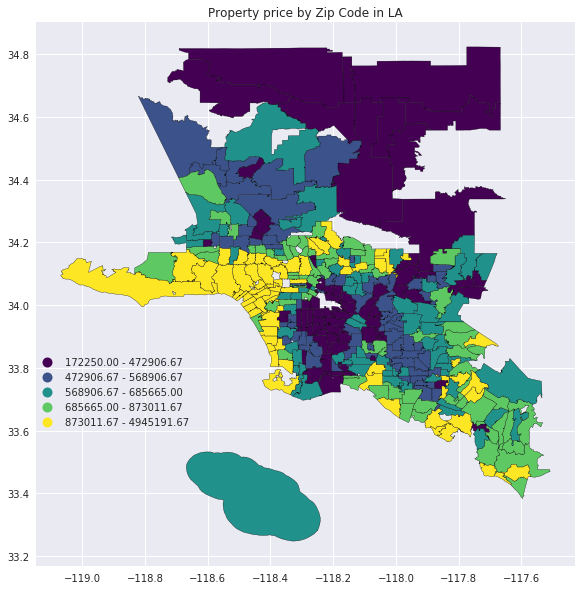

In [67]:
ax = los_angeles1.plot(figsize=(10,10),column='average_hv_2017',cmap='viridis',edgecolor='black',legend=True, scheme = "quantiles")
plt.title("Property price by Zip Code in LA")
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.1, 0.2, 0.2, 0.2))

In [72]:
los_angeles1 = los_angeles1[np.isfinite(los_angeles1['increase_3_year'])]

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


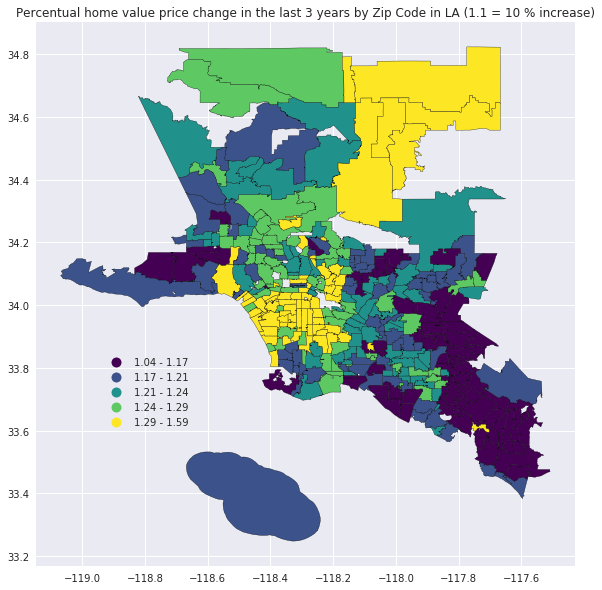

In [73]:
ax = los_angeles1.plot(figsize=(10,10),column='increase_3_year',cmap='viridis',edgecolor='black',legend=True, scheme = "quantiles")
plt.title("Percentual home value price change in the last 3 years by Zip Code in LA (1.1 = 10 % increase)")
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.1, 0.2, 0.2, 0.2))

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


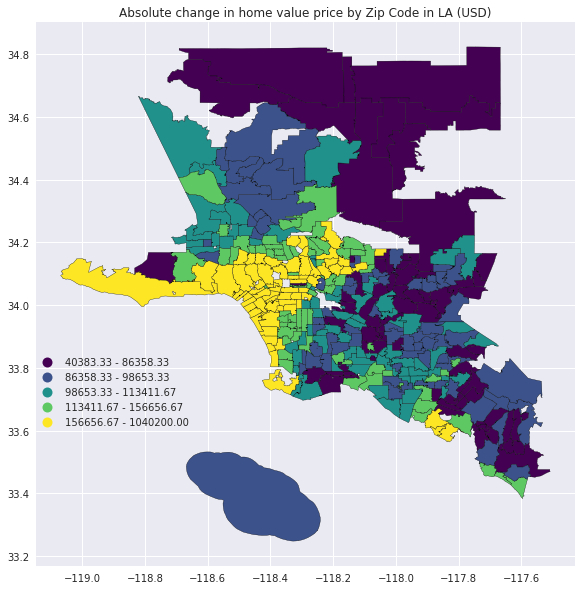

In [74]:
ax = los_angeles1.plot(figsize=(10,10),column='3_year_absolute_hv_increase',cmap='viridis',edgecolor='black',legend=True, scheme = "quantiles")
plt.title("Absolute change in home value price by Zip Code in LA (USD)")
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.1, 0.2, 0.2, 0.2))

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Text(0.5,33,'Percentual home value Increase in last 3 years')

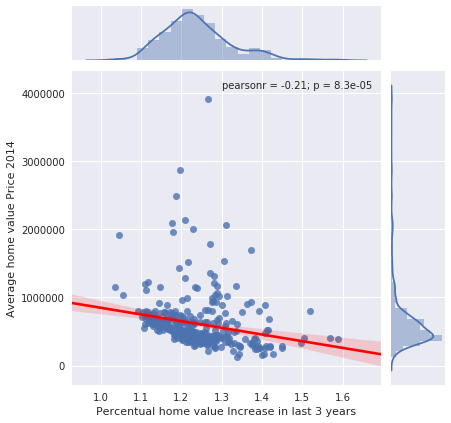

In [80]:
cambio_porcentual1 = sn.jointplot("increase_3_year", "average_hv_2014", data=los_angeles1, kind='reg',
                  joint_kws={'line_kws':{'color':'red'}})
pl.ylabel("Average home value Price 2014")
pl.xlabel("Percentual home value Increase in last 3 years")

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Text(0.5,33,'Absolute home value Increase in last 3 years')

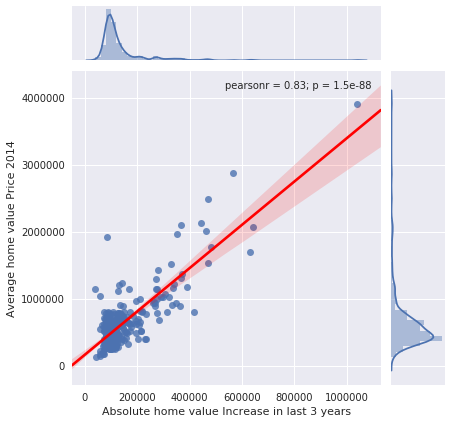

In [79]:
cambio_absoluto1 = sn.jointplot("3_year_absolute_hv_increase", "average_hv_2014", data=los_angeles1, kind='reg',
                  joint_kws={'line_kws':{'color':'red'}})
pl.ylabel("Average home value Price 2014")
pl.xlabel("Absolute home value Increase in last 3 years")

# As expected, the behavior is very similar to the rent prices! the absolute value increase is very closely correlated to the absolute home value, nevertheless you cannot say the same about the porcentual home value increase, where there is a significant negative correlation. This means that expensive properties gain more value in absolute terms, but apparently the percentual increase is lower than cheap properties.

# Now lets do some Time Series Analysis!!! How cool is that?

In [150]:
los_angeles.columns

Index(['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName',
       'SizeRank', '2010-11', '2010-12', '2011-01',
       ...
       'FUNCSTAT10', 'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10',
       'geometry', 'average_rent_2017', 'average_rent_2014', 'increase_3_year',
       '3_year_absolute_rent_increase'],
      dtype='object', length=109)

In [151]:
ts = los_angeles[["2014-01", "2014-02", "2014-03", "2014-04", "2014-05", "2014-06", "2014-07", "2014-08", "2014-09", "2014-10", "2014-11", "2014-12",
                  "2015-01", "2015-02", "2015-03", "2015-04", "2015-05", "2015-06", "2015-07", "2015-08", "2015-09", "2015-10", "2015-11", "2015-12",
                  "2016-01", "2016-02", "2016-03", "2016-04", "2016-05", "2016-06", "2016-07", "2016-08", "2016-09", "2016-10", "2016-11", "2016-12",
                  "2017-01", "2017-02", "2017-03", "2017-04", "2017-05", "2017-06", "2017-07", "2017-08", "2017-09", "2017-10", "2017-11", "2017-12"]]

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


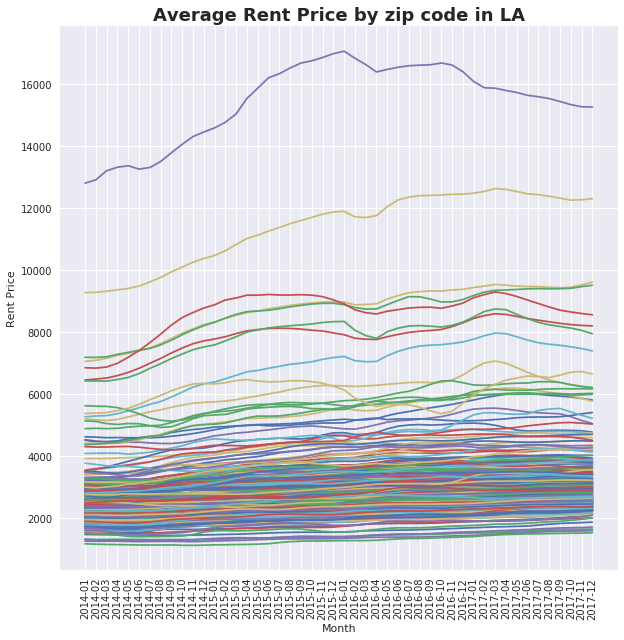

In [152]:


plt.figure(figsize=(10,10))
plt.plot(ts.T);

plt.xlabel('Month')
plt.ylabel('Rent Price')
plt.title('Average Rent Price by zip code in LA', fontsize = 18, fontweight = "bold")
plt.xticks(rotation='vertical');



# Not very useful plot, let's normalize by the mean and the standard deviation and then do some clustering

In [153]:
media=ts.mean(axis=1)
desvio=ts.std(axis=1)

In [154]:
df_norm=[]
df_norm=pd.DataFrame(df_norm)

for i in range (0,len(ts)):
    df_norm=df_norm.append((ts.iloc[i]-media.iloc[i])/desvio.iloc[i])




# Now we make an elbow plot to see how many clusters is a "good" number of cluesters¶


In [155]:
def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(ts) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(ts, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/ts.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(ts)**2)/ts.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


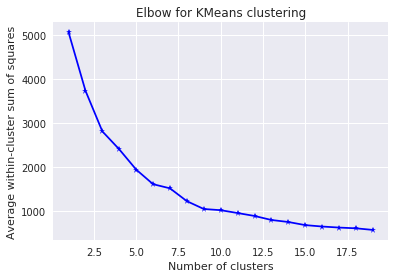

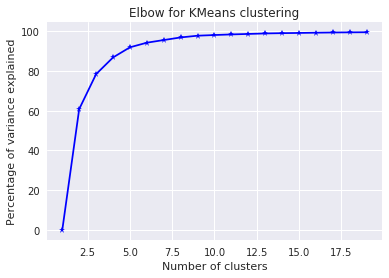

In [156]:
elbow(df_norm,range(1,20))

# It is not very clear, but we will try 5 clusters

# In the following plot we show the normalized behavior of every zipcode, in the color to which cluster they belong. The "thick" more colorful lines (5 of them) represent the mean value for each cluster.

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


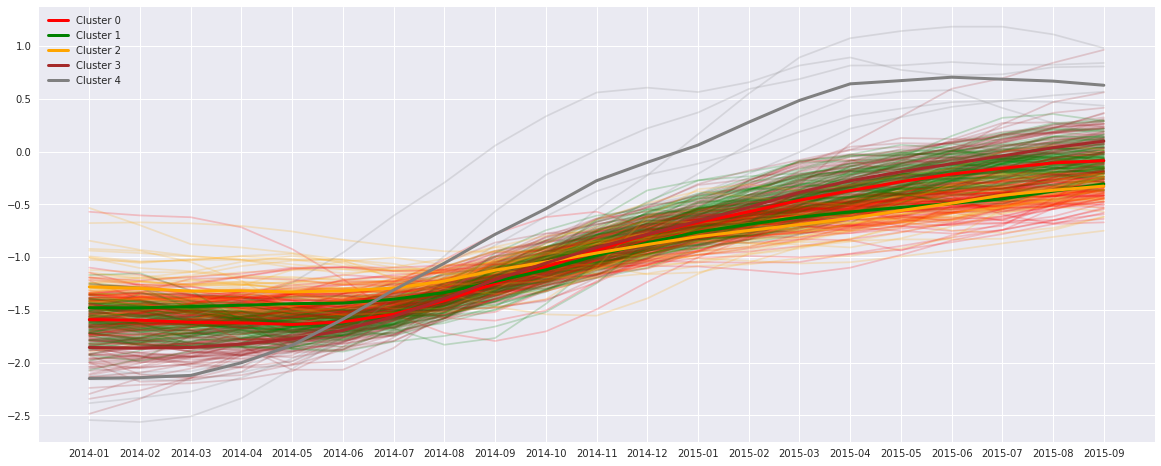

In [157]:

color_map={0:"red",1:"green",2:"orange",3:"brown",4:"grey"}
n=5 # number of clusters
dd=df_norm #data
#tar=y # real target

#train the model.
km=KMeans(random_state=324,n_clusters=n)
res=km.fit(dd)
#result.

df_norm["K_labels_5"]=res.labels_

plt.figure(figsize=(20,8))

for i in range (0,len(df_norm.iloc[:,0:21])):
    plt.plot(df_norm.iloc[i,0:21],color=df_norm["K_labels_5"].replace(color_map).iloc[i],alpha=0.2,label="")

plt.plot(df_norm.iloc[:,0:21][df_norm["K_labels_5"]==1].mean(axis=0),lw=3,label="Cluster 0",color="red", alpha=1)
plt.plot(df_norm.iloc[:,0:21][df_norm["K_labels_5"]==0].mean(axis=0),lw=3,label="Cluster 1",color="green", alpha=1)
plt.plot(df_norm.iloc[:,0:21][df_norm["K_labels_5"]==2].mean(axis=0),lw=3,label="Cluster 2",color="orange", alpha=1)
plt.plot(df_norm.iloc[:,0:21][df_norm["K_labels_5"]==3].mean(axis=0),lw=3,label="Cluster 3",color="brown", alpha=1)
plt.plot(df_norm.iloc[:,0:21][df_norm["K_labels_5"]==4].mean(axis=0),lw=3,label="Cluster 4",color="grey", alpha=1)
plt.legend()



# Based on the graph above, the best investment would be in Cluster 4 (grey) and Cluster 3 (brown) they started with the lowest rent value in 2014 and have the highest now a days.

In [158]:
df_norm["zipcode"] = los_angeles["RegionName"]
df_norm["geometry"] = los_angeles["geometry"]

In [159]:
df_norm.head()

2014-01   2014-02   2014-03   2014-04   2014-05   2014-06   2014-07  \
1 -1.612632 -1.685032 -1.751862 -1.779708 -1.790847 -1.746293 -1.646048   
3 -2.039082 -2.001085 -1.945817 -1.897458 -1.811102 -1.697112 -1.527854   
5 -1.914744 -1.939684 -2.011384 -2.048793 -2.026971 -1.877335 -1.637294   
7 -1.343232 -1.352497 -1.394190 -1.380292 -1.398822 -1.389557 -1.384925   
8 -1.285481 -1.359911 -1.503047 -1.600380 -1.629007 -1.566027 -1.440067   

    2014-08   2014-09   2014-10  \
1 -1.490110 -1.306326 -1.144819   
3 -1.348233 -1.196247 -1.023535   
5 -1.322435 -1.051219 -0.811178   
7 -1.310805 -1.148667 -1.023590   
8 -1.268304 -1.079365 -0.976307   

                         ...                           2017-06   2017-07  \
1                        ...                          1.043877  1.166400   
3                        ...                          0.865935  0.817576   
5                        ...                          0.890932  0.906519   
7                        ...                          1.510389  1.584509   
8                        ...                          1.394025  1.411202   

    2017-08   2017-09   2017-10   2017-11   2017-12  K_labels_5  zipcode  \
1  1.261076  1.333476  1.378030  1.455999  1.556244           1    90250   
3  0.734674  0.675952  0.644864  0.682860  0.679406           3    90046   
5  0.903402  0.922106  0.912754  0.918989  0.887815           3    90034   
7  1.626201  1.626201  1.616936  1.626201  1.663261           2    90044   
8  1.405476  1.445554  1.508534  1.588690  1.657396           2    90805   

                                            geometry  
1  POLYGON ((-118.317782 33.919224, -118.317782 3...  
3  POLYGON ((-118.374841 34.102112, -118.375092 3...  
5  POLYGON ((-118.399868 34.035837, -118.399374 3...  
7  POLYGON ((-118.301381 33.972767, -118.301378 3...  
8  POLYGON ((-118.205486 33.870402, -118.205487 3...  

[5 rows x 51 columns]

In [160]:
df = gp.GeoDataFrame(df_norm)

In [167]:
colors = 5

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


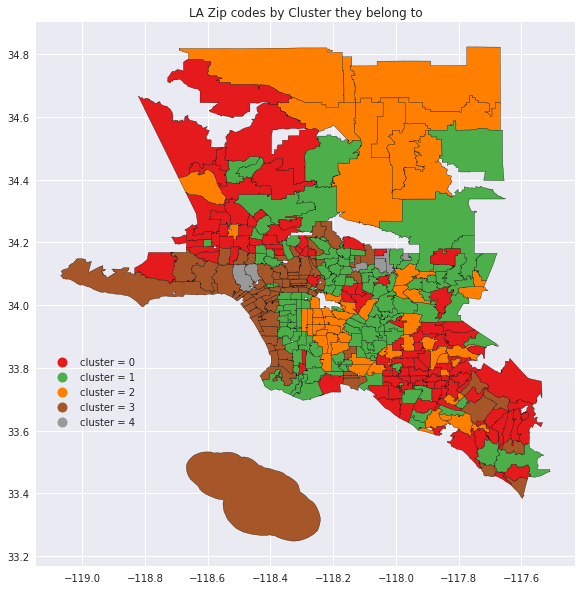

In [179]:
ax = df.plot(figsize=(10,10),column='K_labels_5',cmap='Set1',edgecolor='black',legend=True, scheme = "equal_interval", k = 5)
plt.title("LA Zip codes by Cluster they belong to")
leg = ax.get_legend()
leg.set_bbox_to_anchor((0, 0.2, 0.2, 0.2))
leg.get_texts()[0].set_text('cluster = 0')
leg.get_texts()[1].set_text('cluster = 1')
leg.get_texts()[2].set_text('cluster = 2')
leg.get_texts()[3].set_text('cluster = 3')
leg.get_texts()[4].set_text('cluster = 4')


# When you normalize the time series the results appear to be not to different to what we found when calculating the absolute rent increase between 2014 and 2017. It probably just gives us some extra information, and it is that the best places to invest are the grey zipcodes. Let's see which ones are those.

In [162]:
best_zc = df[df["K_labels_5"] == 4] 


In [164]:
print (best_zc.zipcode.unique())

['90049' '91007' '91006' '91108' '90077' '91008']


# I Strongly recommend you look at this Zipcodes in Google Earth and Google Maps. They have very particular and interesting characteristics. First of all most of them have access to large green areas, also not a large amount of residential areas. Probably the only one that does not follow those characteristics is ZC 91108, located in the San Marino neighborhood in LA. 

# Now lets plot the subway stations on top of that map to see if we can find anything

In [180]:
zip_ref = zipfile.ZipFile("Stations_All_0316.zip", 'r')
zip_ref.extractall()
zip_ref.close()

In [181]:
subway_stops = gp.GeoDataFrame.from_file("Stations_All_0316.shp")

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


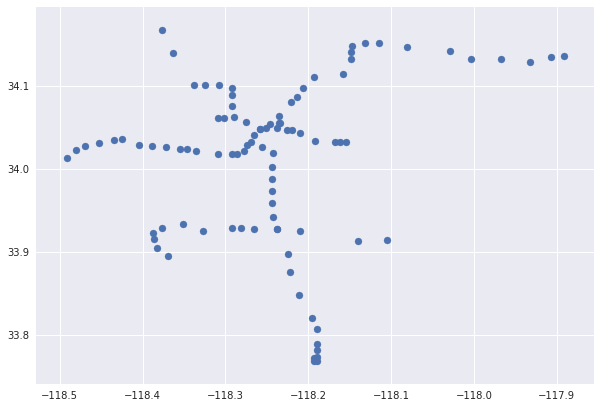

In [182]:
ax = subway_stops.plot(figsize(10,10))

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


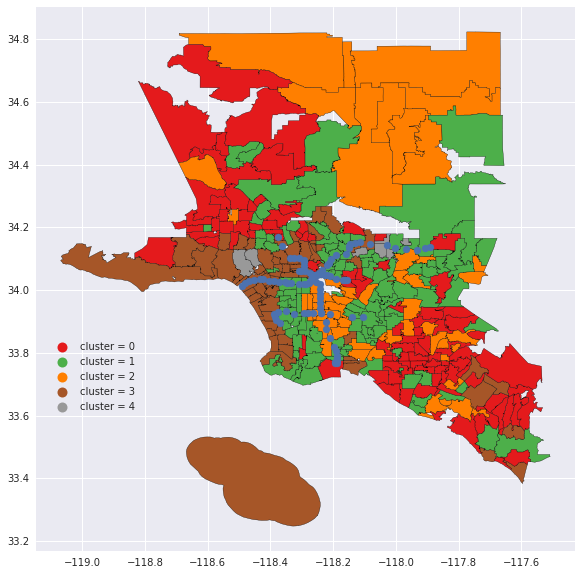

In [192]:
base = df.plot(figsize=(10,10),column='K_labels_5',cmap='Set1',edgecolor='black',legend=True, scheme = "equal_interval", k = 5)
subway_stops.plot(ax=base, legend=True)

leg = base.get_legend()
leg.set_bbox_to_anchor((0, 0.2, 0.2, 0.2))
leg.get_texts()[0].set_text('cluster = 0')
leg.get_texts()[1].set_text('cluster = 1')
leg.get_texts()[2].set_text('cluster = 2')
leg.get_texts()[3].set_text('cluster = 3')
leg.get_texts()[4].set_text('cluster = 4')



# It does not appear to be a correlation between the subway stops and the cluster to which each zip code belongs.

In [221]:
zip_ref = zipfile.ZipFile("DRP_HIGHWAY_PLAN.zip", 'r')
zip_ref.extractall()
zip_ref.close()

In [222]:
highways = gp.GeoDataFrame.from_file("DRP_HIGHWAY_PLAN.shp")

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


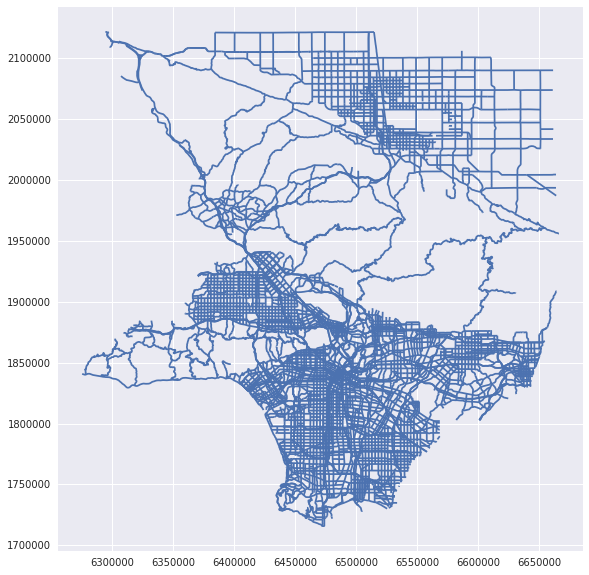

In [223]:
ax = highways.plot(figsize(10,10))

In [224]:
highways.crs

{'datum': 'NAD83',
 'lat_0': 33.5,
 'lat_1': 34.03333333333333,
 'lat_2': 35.46666666666667,
 'lon_0': -118,
 'no_defs': True,
 'proj': 'lcc',
 'units': 'us-ft',
 'x_0': 2000000,
 'y_0': 500000.0000000001}

In [225]:
type(df)

geopandas.geodataframe.GeoDataFrame

In [226]:
subway_stops.crs

{'init': 'epsg:4326'}

In [227]:
type(highways)

geopandas.geodataframe.GeoDataFrame

In [229]:
highways1 = highways.to_crs({'init': 'epsg:4326'})

In [230]:
highways1.crs

{'init': 'epsg:4326'}

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Text(0.5,1,'Clusters with highways')

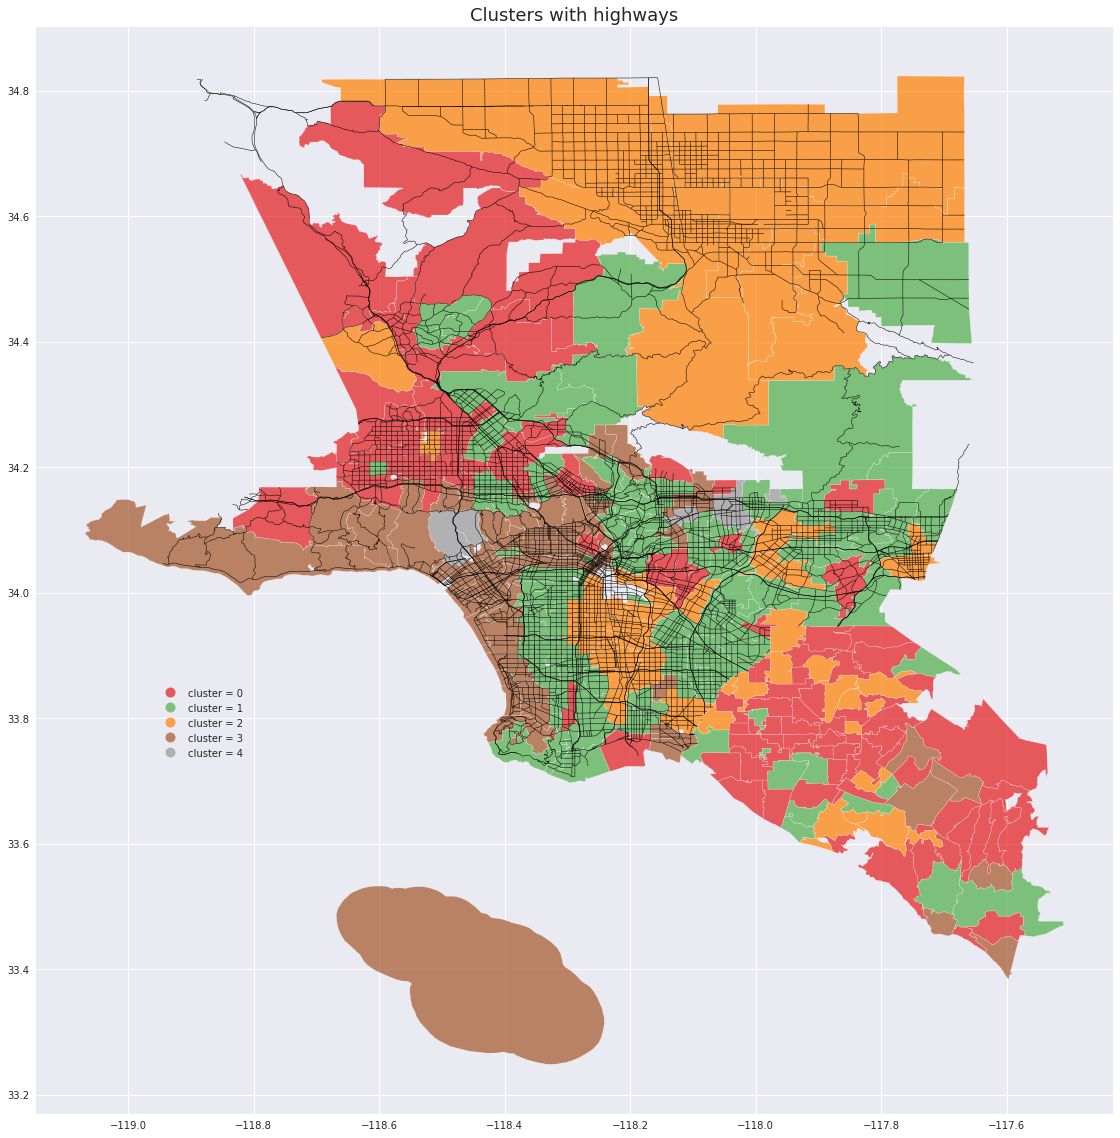

In [251]:
base = df.plot( figsize=(20,20),column='K_labels_5',cmap='Set1',edgecolor='white',legend=True, scheme = "equal_interval", k = 5, alpha = 0.7)

highways1.plot(ax = base,figsize=(20,20),legend=True, color = "k", lw = 0.5)

leg = base.get_legend()
leg.set_bbox_to_anchor((0, 0.2, 0.2, 0.2))
leg.get_texts()[0].set_text('cluster = 0')
leg.get_texts()[1].set_text('cluster = 1')
leg.get_texts()[2].set_text('cluster = 2')
leg.get_texts()[3].set_text('cluster = 3')
leg.get_texts()[4].set_text('cluster = 4')

plt.title("Clusters with highways", fontsize = 18) 

# We are missing the shapefile of roads in the southern part of the metropolitan area. Could not find it so far. But regarding the rest of the map, the clusters do no t appear to have much relation with the roads.

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


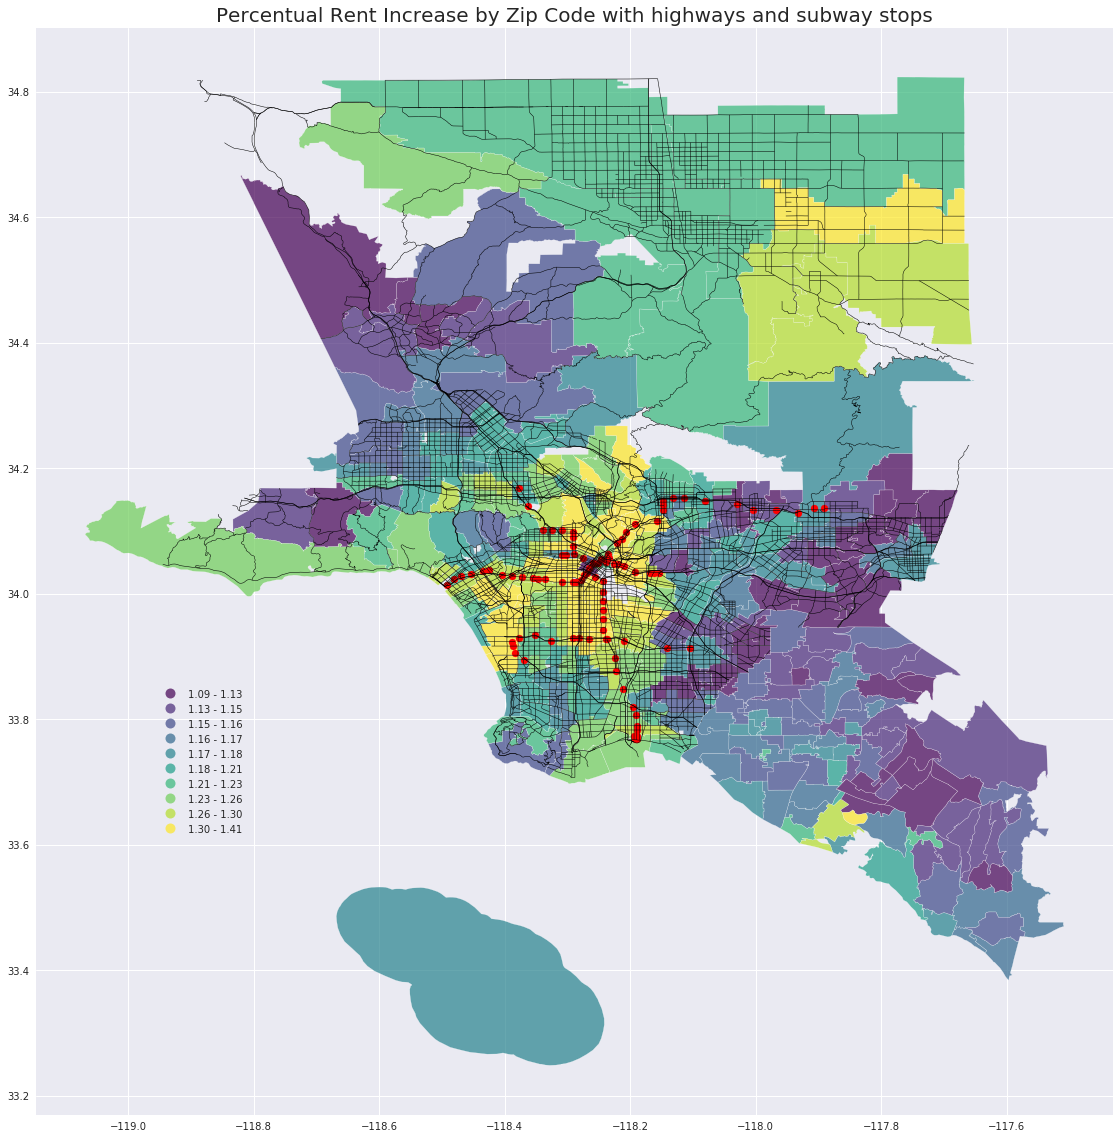

In [264]:
base = los_angeles.plot( figsize=(20,20),column='increase_3_year',cmap='viridis',edgecolor='white',legend=True, scheme = "quantiles", k = 10, alpha = 0.7)

highways1.plot(ax = base,legend=True, color = "k", lw = 0.5)
subway_stops.plot(ax=base, legend=True, color="r")

leg = base.get_legend()
leg.set_bbox_to_anchor((0, 0.2, 0.2, 0.2))

plt.title("Percentual Rent Increase by Zip Code with highways and subway stops", fontsize = 20) 
savefig("Rent_Increase_with_Highways_and_Subway.pdf")
